## Library and Dependency Setup

In [1]:
!pip install kaggle pyspark

In [2]:
# OS & File Handling
import os

# PySpark Core & SQL Functions
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import sum
from pyspark.sql.functions import year
from pyspark.sql.functions import month
from pyspark.sql.functions import dayofmonth
from pyspark.sql.functions import dayofweek
from pyspark.sql.functions import hour
from pyspark.sql.functions import minute
from pyspark.sql.functions import second
from pyspark.sql.functions import expr
from pyspark.sql.functions import log1p
from pyspark.sql.functions import current_date
from pyspark.sql.functions import datediff
from pyspark.sql.functions import min
from pyspark.sql.functions import max

# PySpark ML Feature Engineering
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

# PySpark ML Classification Models
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC

# PySpark ML Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# PySpark Utilities
from pyspark.ml.functions import vector_to_array

# Data Manipulation & Analysis
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Scikit-Learn Metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Dataset Uploading

## Configuring Kaggle API

In [3]:
# Create Kaggle directory if not exists
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Save your Kaggle API token (replace with your own details from kaggle.json)
kaggle_json = '''{
  "username":"kasundivemalya",
  "key":"5c7ca216cfd1c15f2dd1bf255b9a2b66"
}'''

with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    f.write(kaggle_json)

# Set correct file permissions
!chmod 600 ~/.kaggle/kaggle.json

## Downloading Dataset from Kaggle

In [4]:
# Download and unzip dataset into ./data folder
!kaggle datasets download -d priyamchoksi/credit-card-transactions-dataset -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset
License(s): apache-2.0
 81% 118M/145M [00:00<00:00, 1.23GB/s]
100% 145M/145M [00:00<00:00, 1.09GB/s]


## Initializing Spark Session

In [5]:
# Initialize PySpark
spark = SparkSession.builder \
    .appName("CreditCardFraudDetection") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print("Spark Session Created Successfully!")

Spark Session Created Successfully!


## Loading Dataset into Spark DataFrame

In [6]:
# Adjust filename if needed (check ./data/ after download)
data_path = "./data/credit_card_transactions.csv"

# Load dataset with headers and schema inference
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Initial Data Inspection

## Dimension of the Dataset

In [7]:
# Row count
print("Total rows:", df.count())

# Column count
print("Total columns:", len(df.columns))

Total rows: 1296675
Total columns: 24


## Column Names of the Dataset

In [8]:
# Get all column names
print("Column names:")
for col in df.columns:
    print(col)

Column names:
Unnamed: 0
trans_date_trans_time
cc_num
merchant
category
amt
first
last
gender
street
city
state
zip
lat
long
city_pop
job
dob
trans_num
unix_time
merch_lat
merch_long
is_fraud
merch_zipcode


## Schema of the Dataset

In [9]:
# Print schema of the dataset
df.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_zipcode: integer (nullable = true)



## Checking Class Distribution (Fraud vs Non-Fraud)

In [10]:
df.groupBy("is_fraud").count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   7506|
|       0|1289169|
+--------+-------+



## Quick Sample of the Dataset

In [11]:
# Show 10 random transactions
df.sample(fraction=0.00001).show(10, truncate=False)

+----------+---------------------+----------------+------------------------------------+--------------+-----+--------+-------+------+----------------------------------+-------------+-----+-----+-------+---------+--------+-------------------------------------------+----------+--------------------------------+----------+------------------+------------------+--------+-------------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                            |category      |amt  |first   |last   |gender|street                            |city         |state|zip  |lat    |long     |city_pop|job                                        |dob       |trans_num                       |unix_time |merch_lat         |merch_long        |is_fraud|merch_zipcode|
+----------+---------------------+----------------+------------------------------------+--------------+-----+--------+-------+------+----------------------------------+-------------+-----+-----+-------+---------+--------+---------------

# Data Cleaning & Preprocessing

## Checking for Duplicates

In [12]:
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


## Checking for Missing Values

In [13]:
# Count null values in each column
from pyspark.sql.functions import col
from pyspark.sql.functions import sum

null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show(vertical=True)

-RECORD 0-----------------------
 Unnamed: 0            | 0      
 trans_date_trans_time | 0      
 cc_num                | 0      
 merchant              | 0      
 category              | 0      
 amt                   | 0      
 first                 | 0      
 last                  | 0      
 gender                | 0      
 street                | 0      
 city                  | 0      
 state                 | 0      
 zip                   | 0      
 lat                   | 0      
 long                  | 0      
 city_pop              | 0      
 job                   | 0      
 dob                   | 0      
 trans_num             | 0      
 unix_time             | 0      
 merch_lat             | 0      
 merch_long            | 0      
 is_fraud              | 0      
 merch_zipcode         | 195973 



### Dropping the Missing Values

In [14]:
# Drop rows where 'merch_zipcode' is null
df=df.dropna(subset=["merch_zipcode"])

# Check null counts for 'merch_zipcode'
df.select(sum(col("merch_zipcode").isNull().cast("int")).alias("merch_zipcode")).show(vertical=True)

-RECORD 0------------
 merch_zipcode | 0   



## Feature Engineering

### Temporal Features

In [15]:
# Extract year, month, day, weekday, hour, minute, second
df = (
    df.withColumn("trans_year", year("trans_date_trans_time"))
      .withColumn("trans_month", month("trans_date_trans_time"))
      .withColumn("trans_day", dayofmonth("trans_date_trans_time"))
      .withColumn("trans_weekday", dayofweek("trans_date_trans_time") - 1)  # 0=Monday, 6=Sunday
      .withColumn("trans_hour", hour("trans_date_trans_time"))
      .withColumn("trans_minute", minute("trans_date_trans_time"))
      .withColumn("trans_second", second("trans_date_trans_time"))
)

In [16]:
# Season feature (1=Winter, 2=Spring, 3=Summer, 4=Autumn)
df = df.withColumn("trans_season", expr("((month(trans_date_trans_time) % 12) / 3 + 1)"))
df.select("trans_year","trans_month","trans_day","trans_weekday","trans_hour","trans_minute","trans_second","trans_season").show(5)

+----------+-----------+---------+-------------+----------+------------+------------+------------------+
|trans_year|trans_month|trans_day|trans_weekday|trans_hour|trans_minute|trans_second|      trans_season|
+----------+-----------+---------+-------------+----------+------------+------------+------------------+
|      2019|          1|        1|            2|         0|           0|          18|1.3333333333333333|
|      2019|          1|        1|            2|         0|           0|          51|1.3333333333333333|
|      2019|          1|        1|            2|         0|           3|           6|1.3333333333333333|
|      2019|          1|        1|            2|         0|           4|           8|1.3333333333333333|
|      2019|          1|        1|            2|         0|           5|           8|1.3333333333333333|
+----------+-----------+---------+-------------+----------+------------+------------+------------------+
only showing top 5 rows



### Log Transformation of Transaction Amount

In [17]:
df = df.withColumn("log_amt", log1p("amt")) # log1p(x) = log(1+x), avoids log(0) issue
df.select("amt","log_amt").show(5)

+------+------------------+
|   amt|           log_amt|
+------+------------------+
|  4.97|1.7867469274045107|
|220.11| 5.398660315244065|
| 41.96|3.7602694502006093|
| 94.63| 4.560486578361451|
| 71.65| 4.285653390016292|
+------+------------------+
only showing top 5 rows



### Cardholder's Age

In [18]:
# Calculate age at the time of transaction
df = df.withColumn(
    "cardholder_age",
    (datediff(col("trans_date_trans_time"), col("dob")) / 365.25).cast("int")
)

df.select("dob", "trans_date_trans_time", "cardholder_age").show(5)

+----------+---------------------+--------------+
|       dob|trans_date_trans_time|cardholder_age|
+----------+---------------------+--------------+
|1988-03-09|  2019-01-01 00:00:18|            30|
|1962-01-19|  2019-01-01 00:00:51|            56|
|1986-03-28|  2019-01-01 00:03:06|            32|
|1961-06-19|  2019-01-01 00:04:08|            57|
|1947-08-21|  2019-01-01 00:05:08|            71|
+----------+---------------------+--------------+
only showing top 5 rows



## Outlier Detection

In [19]:
numeric_cols = [c for c, t in df.dtypes if t in ("double", "int", "float", "long")]

for col_name in numeric_cols:
    # Calculate Q1, Q3, IQR
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    if len(quantiles) == 2:
        Q1, Q3 = quantiles
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_count = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound)).count()
        print(f"{col_name}: {outlier_count} potential outliers")

Unnamed: 0: 0 potential outliers
amt: 67288 potential outliers
zip: 0 potential outliers
lat: 1975 potential outliers
long: 67010 potential outliers
city_pop: 244426 potential outliers
unix_time: 0 potential outliers
merch_lat: 1383 potential outliers
merch_long: 67920 potential outliers
is_fraud: 6363 potential outliers
merch_zipcode: 0 potential outliers
trans_year: 0 potential outliers
trans_month: 0 potential outliers
trans_day: 0 potential outliers
trans_weekday: 0 potential outliers
trans_hour: 0 potential outliers
trans_minute: 0 potential outliers
trans_second: 0 potential outliers
trans_season: 0 potential outliers
log_amt: 1121 potential outliers
cardholder_age: 4278 potential outliers


### Range Validation of Outlier-Flagged Columns

In [20]:
# Columns to check
cols_to_check = ["lat", "long", "city_pop", "merch_lat", "merch_long", "cardholder_age"]

# Compute min and max for each column
for col_name in cols_to_check:
    stats = df.select(
        min(col_name).alias("min_val"),
        max(col_name).alias("max_val")
    ).collect()[0]

    print(f"{col_name}: Min = {stats['min_val']}, Max = {stats['max_val']}")

lat: Min = 20.0271, Max = 48.8878
long: Min = -155.488, Max = -67.9503
city_pop: Min = 23, Max = 2906700
merch_lat: Min = 19.352471, Max = 49.128218
merch_long: Min = -156.487735, Max = -66.955996
cardholder_age: Min = 13, Max = 95


## Encoding Relevant Categorical Variables

In [21]:
# Categorical columns
categorical_cols = ["merchant", "category", "gender", "job"]

# Indexers
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep")
            for col in categorical_cols]

# Build pipeline
pipeline_index_only = Pipeline(stages=indexers)

# Transform
df= pipeline_index_only.fit(df).transform(df)

print("Indexed columns ready for tree-based models:")
df.select("merchant", "merchant_index", "category", "category_index", "gender", "gender_index", "job", "job_index").show(5, truncate=False)

Indexed columns ready for tree-based models:
+--------------------------------+--------------+-------------+--------------+------+------------+------------------------------+---------+
|merchant                        |merchant_index|category     |category_index|gender|gender_index|job                           |job_index|
+--------------------------------+--------------+-------------+--------------+------+------------+------------------------------+---------+
|fraud_Rippin, Kub and Mann      |565.0         |misc_net     |11.0          |F     |0.0         |Psychologist, counselling     |93.0     |
|fraud_Lind-Buckridge            |314.0         |entertainment|6.0           |M     |1.0         |Nature conservation officer   |458.0    |
|fraud_Keeling-Crist             |523.0         |misc_pos     |10.0          |M     |1.0         |Dance movement psychotherapist|238.0    |
|fraud_Stroman, Hudson and Erdman|16.0          |gas_transport|0.0           |F     |0.0         |Transport planner

# Exploratory Data Analysis (EDA)

## Summary Statistics for Numerical Columns

In [22]:
# Numeric column summary
numeric_cols = [c for c, t in df.dtypes if t in ("double", "int", "float", "long")]
df.select(numeric_cols).describe().show()

+-------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+--------------------+-----------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+----------------+------------------+------------------+
|summary|       Unnamed: 0|               amt|              zip|              lat|              long|         city_pop|           unix_time|        merch_lat|        merch_long|            is_fraud|    merch_zipcode|        trans_year|       trans_month|         trans_day|     trans_weekday|        trans_hour|      trans_minute|      trans_second|      trans_season|           log_amt|    cardholder_age|   merchant_index|  category_index|      gender_index|         job_index|
+-------+-----------------+-------------

## Summary Statistics for Categorical Columns

In [23]:
# Summary statistics for categorical columns
categorical_cols = [c for c, t in df.dtypes if t == "string"]

for col_name in categorical_cols:
    print(f"Column: {col_name}")
    df.groupBy(col_name).count().show(5)  # top 5 values

Column: merchant
+--------------------+-----+
|            merchant|count|
+--------------------+-----+
|  fraud_Rau and Sons| 2127|
|fraud_O'Hara-Wild...| 1538|
|fraud_Bradtke, To...| 1579|
|     fraud_Thiel PLC| 1314|
|    fraud_Herman Inc| 1354|
+--------------------+-----+
only showing top 5 rows

Column: category
+------------+------+
|    category| count|
+------------+------+
|      travel| 34503|
|    misc_net| 53475|
| grocery_pos|104942|
|   kids_pets| 95954|
|shopping_net| 82440|
+------------+------+
only showing top 5 rows

Column: first
+-------+-----+
|  first|count|
+-------+-----+
|  Tyler| 5873|
|Shannon| 5937|
|Carolyn| 2563|
|  Shawn|  996|
|  Scott| 8126|
+-------+-----+
only showing top 5 rows

Column: last
+---------+-----+
|     last|count|
+---------+-----+
|    Tyler|  995|
|    Roach|  205|
|Castaneda| 1026|
|   Grimes| 3688|
| Thornton| 2136|
+---------+-----+
only showing top 5 rows

Column: gender
+------+------+
|gender| count|
+------+------+
|     F|599

## Converting Entire Spark DF to Pandas for Visualization

In [24]:
# Collect entire dataset into Pandas
eda_df = df.toPandas()
print(eda_df.shape)

(1100702, 38)


## Fraud vs Non-Fraud Count

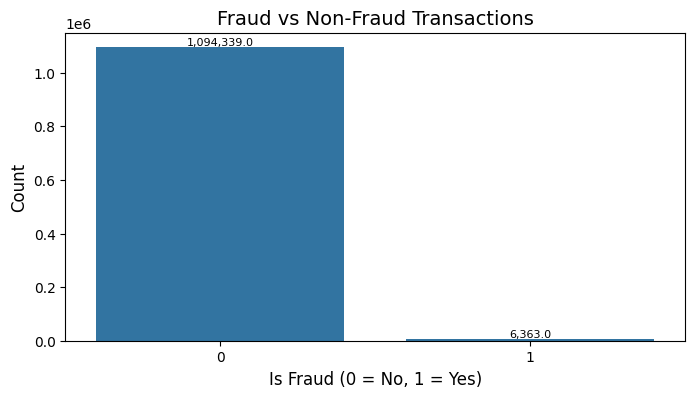

In [25]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x="is_fraud", data=eda_df)

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom", fontsize=8, color="black")

plt.title("Fraud vs Non-Fraud Transactions", fontsize=14)
plt.xlabel("Is Fraud (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

## Fraud vs Non-Fraud Distribution by Spending Category

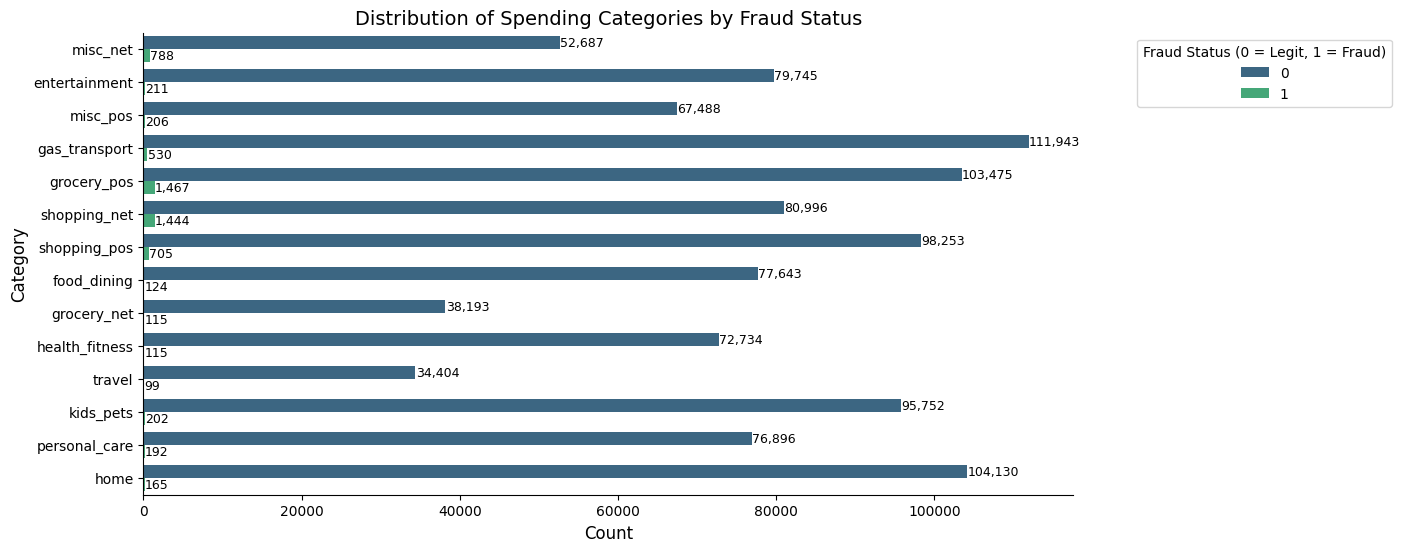

In [26]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(y="category", hue="is_fraud", data=eda_df, palette="viridis")

plt.title("Distribution of Spending Categories by Fraud Status", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.legend(title="Fraud Status (0 = Legit, 1 = Fraud)",
           loc="upper right", bbox_to_anchor=(1.35, 1))

# Remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate counts
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + 20,
                p.get_y() + p.get_height()/2,
                f"{int(width):,}",
                ha="left", va="center", fontsize=9)
plt.show()

## Fraud vs Non-Fraud Distribution by Gender

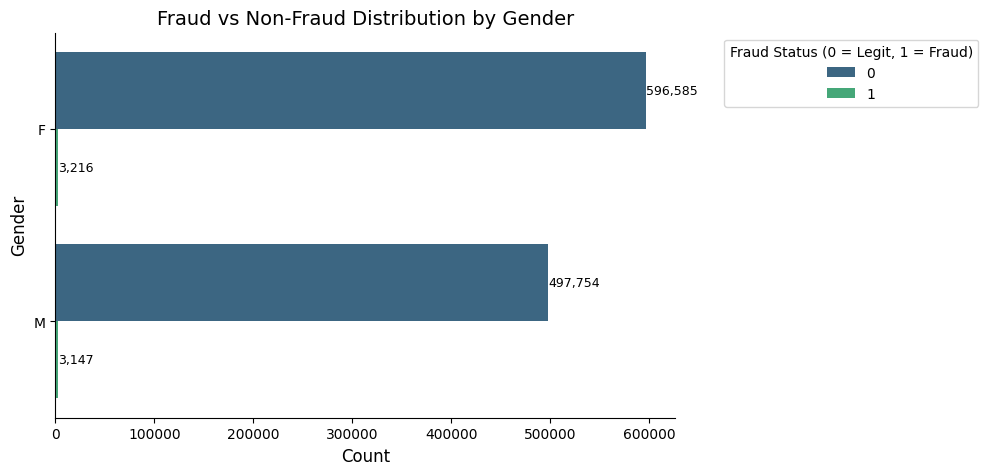

In [27]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(y="gender", hue="is_fraud", data=eda_df, palette="viridis")

plt.title("Fraud vs Non-Fraud Distribution by Gender", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Gender", fontsize=12)
plt.legend(title="Fraud Status (0 = Legit, 1 = Fraud)",
           loc="upper right", bbox_to_anchor=(1.5, 1))

# Remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate counts
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + 20,
                p.get_y() + p.get_height()/2,
                f"{int(width):,}",
                ha="left", va="center", fontsize=9)

plt.show()

## Fraud vs Non-Fraud Distribution by Age

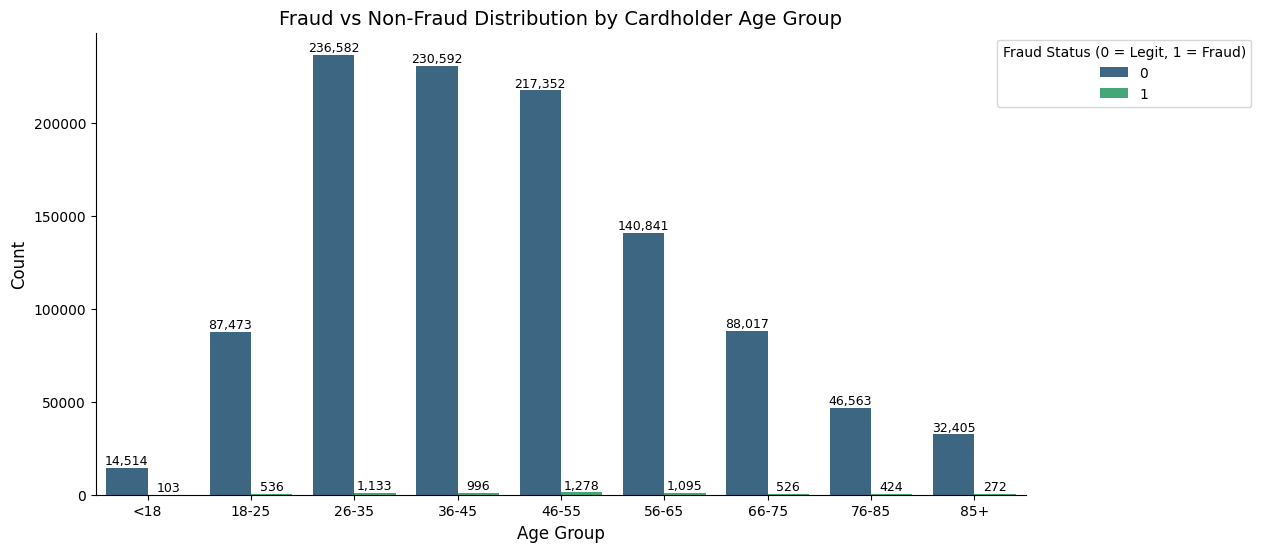

In [28]:
# Create age bins
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ["<18", "18-25", "26-35", "36-45", "46-55", "56-65", "66-75", "76-85", "85+"]
eda_df["age_group"] = pd.cut(eda_df["cardholder_age"], bins=bins, labels=labels, right=False)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="age_group", hue="is_fraud", data=eda_df, palette="viridis")

plt.title("Fraud vs Non-Fraud Distribution by Cardholder Age Group", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Fraud Status (0 = Legit, 1 = Fraud)", loc="upper right", bbox_to_anchor=(1.25, 1))

# Remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate counts
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2,
                height + 200,  # offset for visibility
                f"{int(height):,}",
                ha="center", va="bottom", fontsize=9)

plt.show()

## Fraud vs Non-Fraud Distribution by Transaction Amount

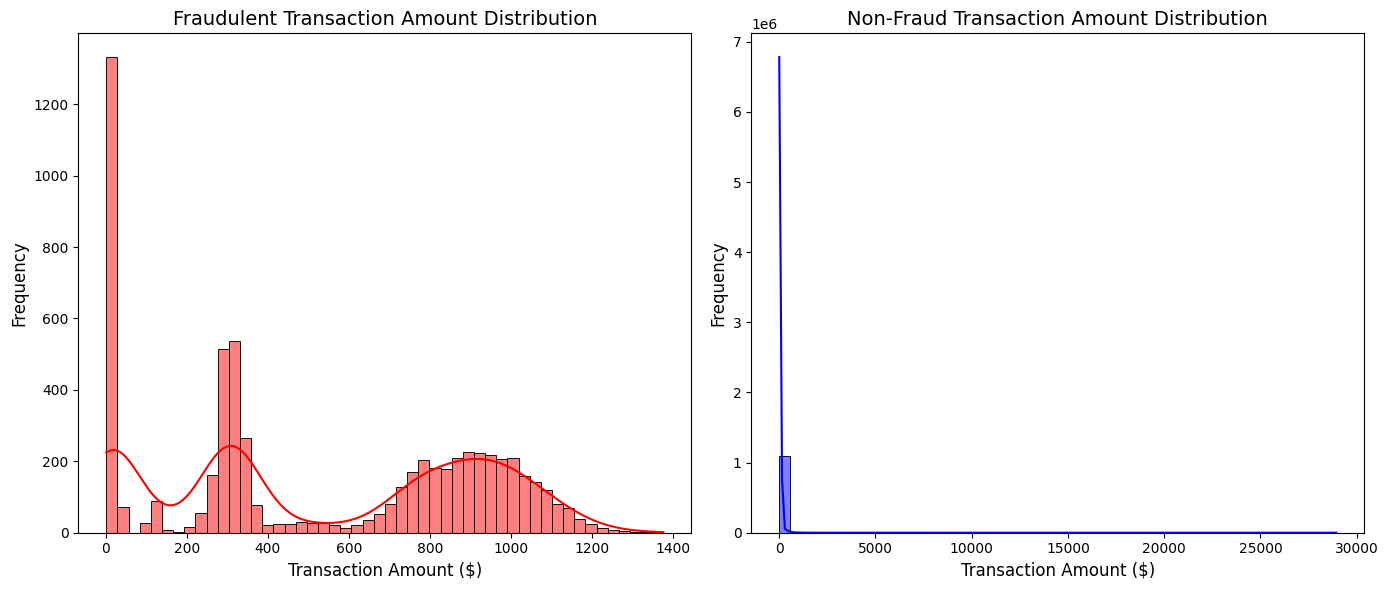

In [29]:
plt.figure(figsize=(14, 6))

# Fraudulent
plt.subplot(1, 2, 1)
sns.histplot(eda_df[eda_df['is_fraud'] == 1]['amt'], bins=50, kde=True, color='red')
plt.title('Fraudulent Transaction Amount Distribution', fontsize=14)
plt.xlabel('Transaction Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Non-Fraudulent
plt.subplot(1, 2, 2)
sns.histplot(eda_df[eda_df['is_fraud'] == 0]['amt'], bins=50, kde=True, color='blue')
plt.title('Non-Fraud Transaction Amount Distribution', fontsize=14)
plt.xlabel('Transaction Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

## Fraud vs Non-Fraud Distribution by Logged Transaction Amount

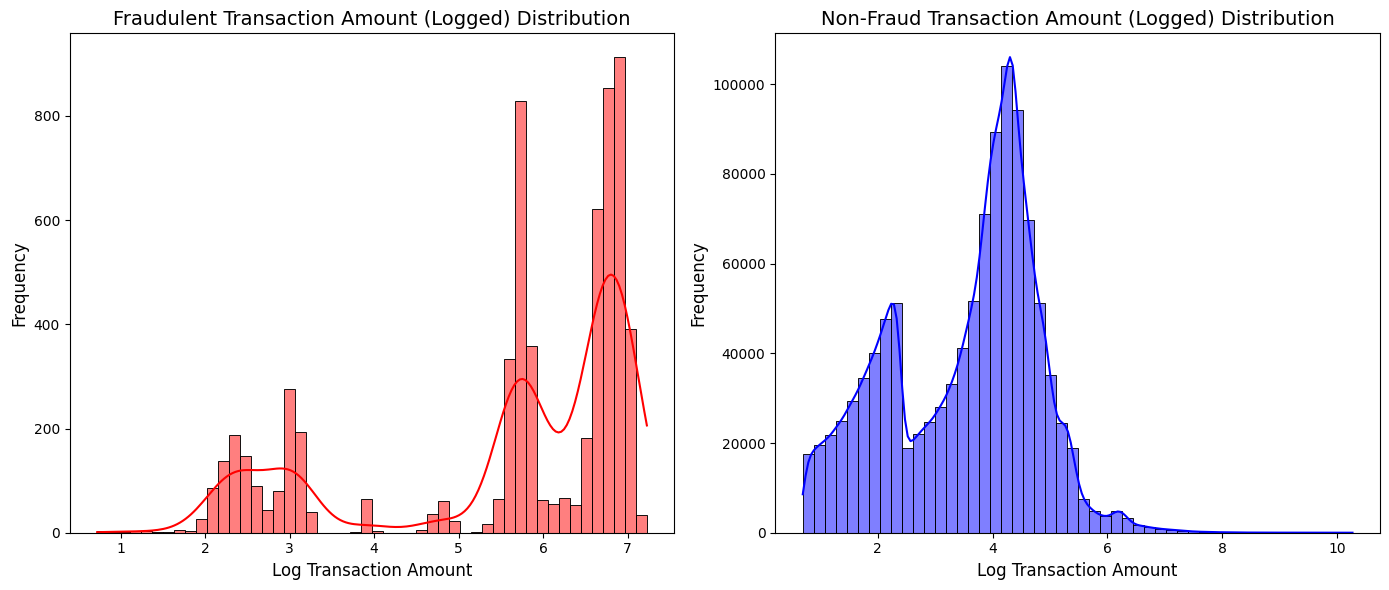

In [30]:
plt.figure(figsize=(14, 6))

# Fraudulent
plt.subplot(1, 2, 1)
sns.histplot(eda_df[eda_df['is_fraud'] == 1]['log_amt'], bins=50, kde=True, color='red')
plt.title('Fraudulent Transaction Amount (Logged) Distribution', fontsize=14)
plt.xlabel('Log Transaction Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Non-Fraudulent
plt.subplot(1, 2, 2)
sns.histplot(eda_df[eda_df['is_fraud'] == 0]['log_amt'], bins=50, kde=True, color='blue')
plt.title('Non-Fraud Transaction Amount (Logged) Distribution', fontsize=14)
plt.xlabel('Log Transaction Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

## Fraud vs Non-Fraud Distribution by City Population

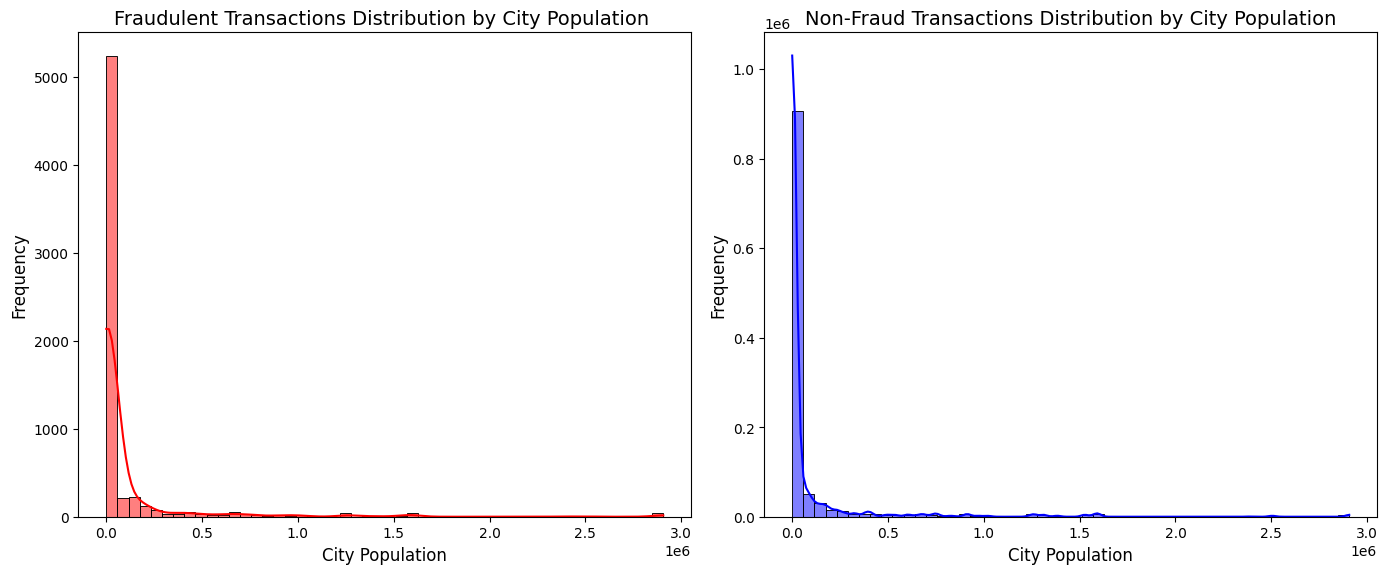

In [31]:
plt.figure(figsize=(14, 6))

# Fraudulent
plt.subplot(1, 2, 1)
sns.histplot(eda_df[eda_df['is_fraud'] == 1]['city_pop'], bins=50, kde=True, color='red')
plt.title('Fraudulent Transactions Distribution by City Population ', fontsize=14)
plt.xlabel('City Population', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Non-Fraudulent
plt.subplot(1, 2, 2)
sns.histplot(eda_df[eda_df['is_fraud'] == 0]['city_pop'], bins=50, kde=True, color='blue')
plt.title('Non-Fraud Transactions Distribution by City Population', fontsize=14)
plt.xlabel('City Population', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

## Fraud vs Non-Fraud Distribution by Hour of Day

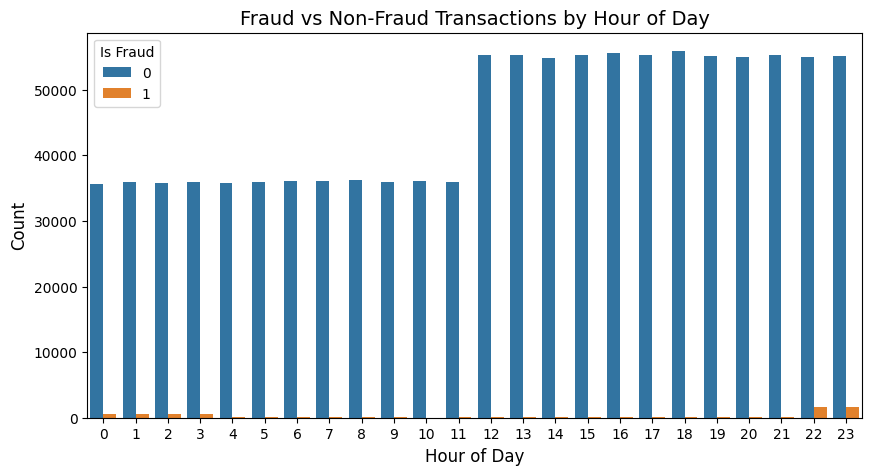

In [32]:
plt.figure(figsize=(10,5))
sns.countplot(x="trans_hour", hue="is_fraud", data=eda_df)
plt.title("Fraud vs Non-Fraud Transactions by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Is Fraud")
plt.show()

## Top 10 Merchants by Fraud Transaction Amount

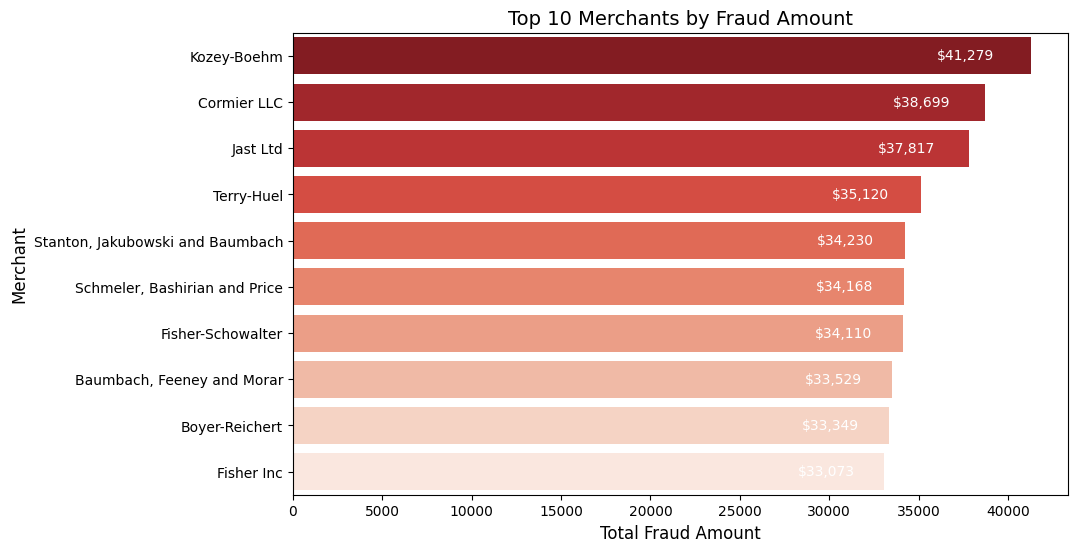

In [33]:
# Top merchants by fraud amount
top_merchants_amount = (eda_df[eda_df['is_fraud'] == 1]
                        .groupby('merchant')['amt']
                        .sum()
                        .sort_values(ascending=False)
                        .head(10)
                        .reset_index())

# Clean merchant names
top_merchants_amount['merchant'] = top_merchants_amount['merchant'].str.replace("fraud_", "", regex=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x='amt',
    y='merchant',
    data=top_merchants_amount,
    hue='merchant',
    palette="Reds_r"
)

plt.title("Top 10 Merchants by Fraud Amount", fontsize=14)
plt.xlabel("Total Fraud Amount", fontsize=12)
plt.ylabel("Merchant", fontsize=12)

# Annotate amounts inside the bars
for i, row in top_merchants_amount.iterrows():
    plt.text(row['amt'] - row['amt']*0.05, i, f"${row['amt']:,.0f}", va='center', ha='right', color='white', fontsize=10)

plt.show()

##  Average Percentage of Fraud Transactions for Each Day of the Week

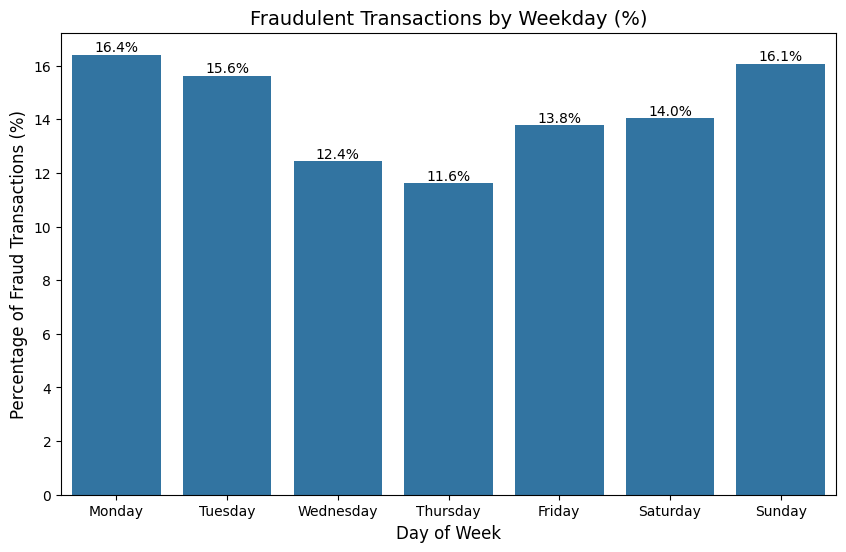

In [34]:
# Fraud transactions only
fraud_transactions = eda_df[eda_df['is_fraud'] == 1]

# Count fraud per weekday
weekday_fraud_counts = fraud_transactions['trans_weekday'].value_counts().sort_index()

# Normalize (percentage distribution)
average_weekday_fraud_counts = weekday_fraud_counts / weekday_fraud_counts.sum() * 100

# Day labels
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.barplot(x=average_weekday_fraud_counts.index,
            y=average_weekday_fraud_counts.values)

plt.title('Fraudulent Transactions by Weekday (%)', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Percentage of Fraud Transactions (%)', fontsize=12)
plt.xticks(ticks=range(7), labels=days_of_week, rotation=0)

# Annotate percentages on bars
for i, count in enumerate(average_weekday_fraud_counts.values):
    plt.text(i, count, f"{count:.1f}%", ha='center', va='bottom', fontsize=10)

plt.show()

## Fraudulent Transactions Over Time (Monthly)

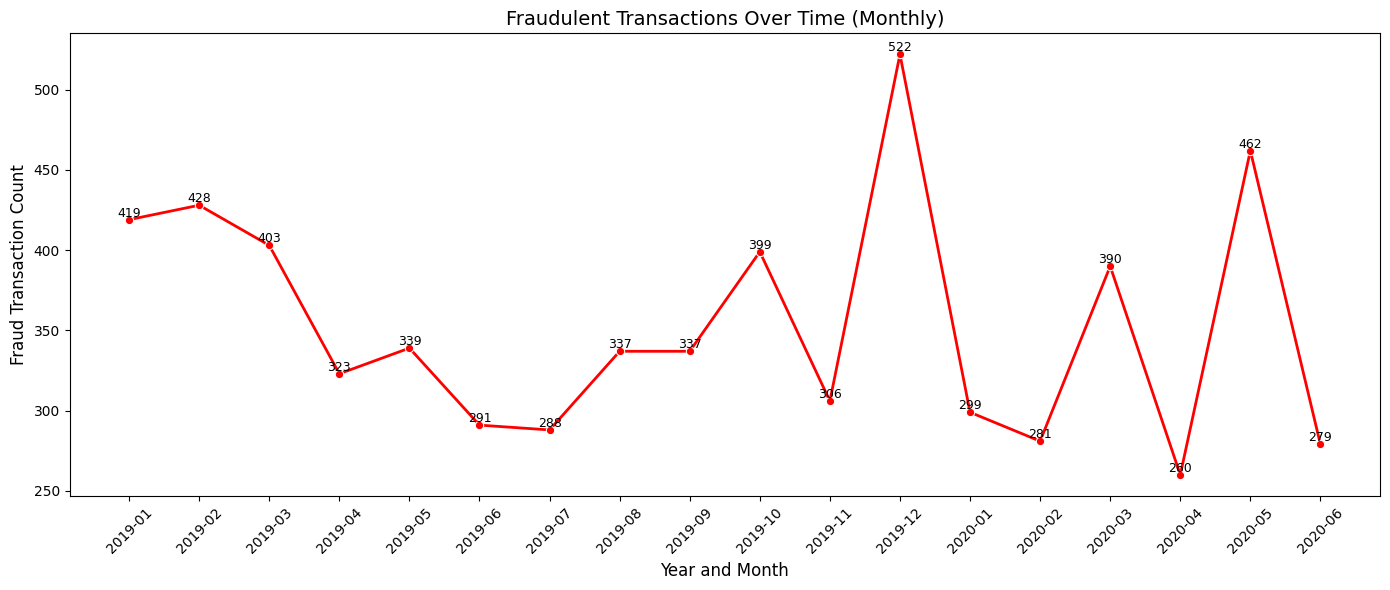

In [35]:
# Fraud transactions only (make a copy to avoid SettingWithCopyWarning)
fraud_transactions = eda_df[eda_df['is_fraud'] == 1].copy()

# Create Year-Month column
fraud_transactions['year_month'] = (
    fraud_transactions['trans_year'].astype(str) + "-" +
    fraud_transactions['trans_month'].astype(str).str.zfill(2)
)

# Count fraud per year-month
monthly_fraud_counts = fraud_transactions['year_month'].value_counts().sort_index()

plt.figure(figsize=(14,6))
sns.lineplot(
    x=monthly_fraud_counts.index,
    y=monthly_fraud_counts.values,
    marker="o", linewidth=2, color="red"
)

plt.title("Fraudulent Transactions Over Time (Monthly)", fontsize=14)
plt.xlabel("Year and Month", fontsize=12)
plt.ylabel("Fraud Transaction Count", fontsize=12)
plt.xticks(rotation=45)

# Annotate values
for i, count in enumerate(monthly_fraud_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Average Fraud Transaction Amount per Season

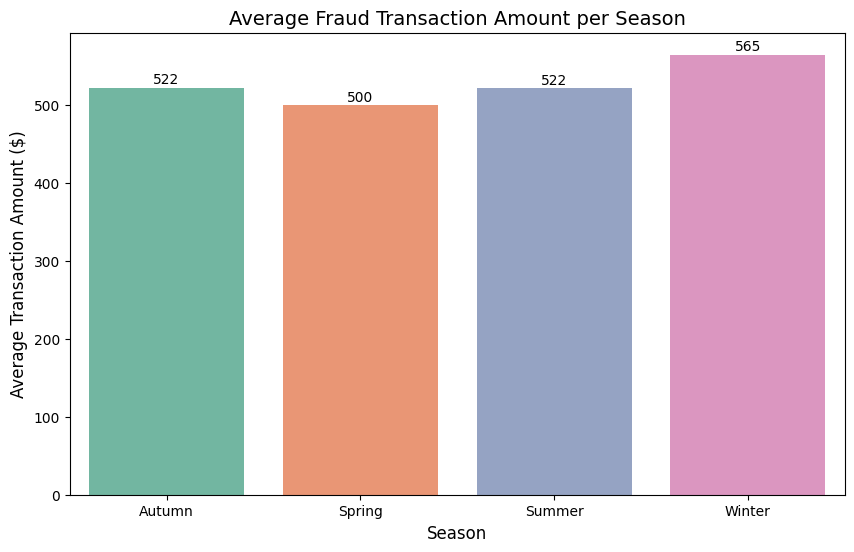

In [36]:
fraud_transactions = eda_df[eda_df['is_fraud'] == 1].copy()

# Map season numbers to names
season_mapping = {1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"}
fraud_transactions['season'] = fraud_transactions['trans_season'].map(season_mapping)

avg_amt_per_season = fraud_transactions.groupby("season")["amt"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="season", y="amt", hue="season", data=avg_amt_per_season,
            palette="Set2")
plt.title("Average Fraud Transaction Amount per Season", fontsize=14)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Average Transaction Amount ($)", fontsize=12)

# Annotate values
for i, row in avg_amt_per_season.iterrows():
    plt.text(i, row["amt"]+5, f"{row['amt']:.0f}", ha="center")

plt.show()

## Top 10 Cities with Fraud Transaction Amounts

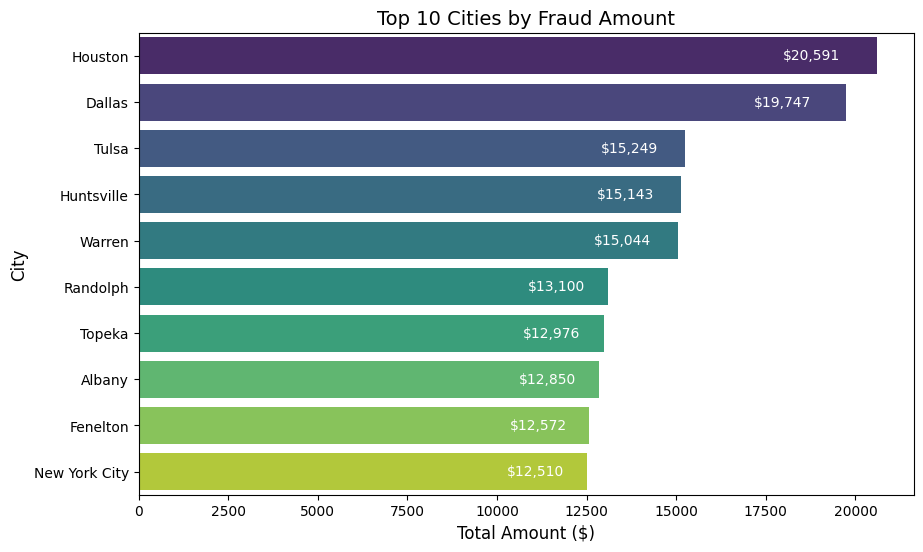

In [37]:
# Filter only fraud transactions
fraud_transactions = eda_df[eda_df['is_fraud'] == 1].copy()

# Top 10 cities by total fraud amount
fraud_by_city = (fraud_transactions
                 .groupby('city')['amt']
                 .sum()
                 .sort_values(ascending=False)
                 .head(10)
                 .reset_index())

fraud_by_city.columns = ['city', 'total_amt']

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x='total_amt',
    y='city',
    data=fraud_by_city,
    hue='city',
    palette='viridis'
)
plt.title("Top 10 Cities by Fraud Amount", fontsize=14)
plt.xlabel("Total Amount ($)", fontsize=12)
plt.ylabel("City", fontsize=12)

# Annotate amounts inside bars
for i, row in fraud_by_city.iterrows():
    plt.text(row['total_amt'] - row['total_amt']*0.05, i, f"${row['total_amt']:,.0f}",
             va='center', ha='right', color='white', fontsize=10)

plt.show()

## Top 10 Cities with Non-Fraud Transaction Amounts

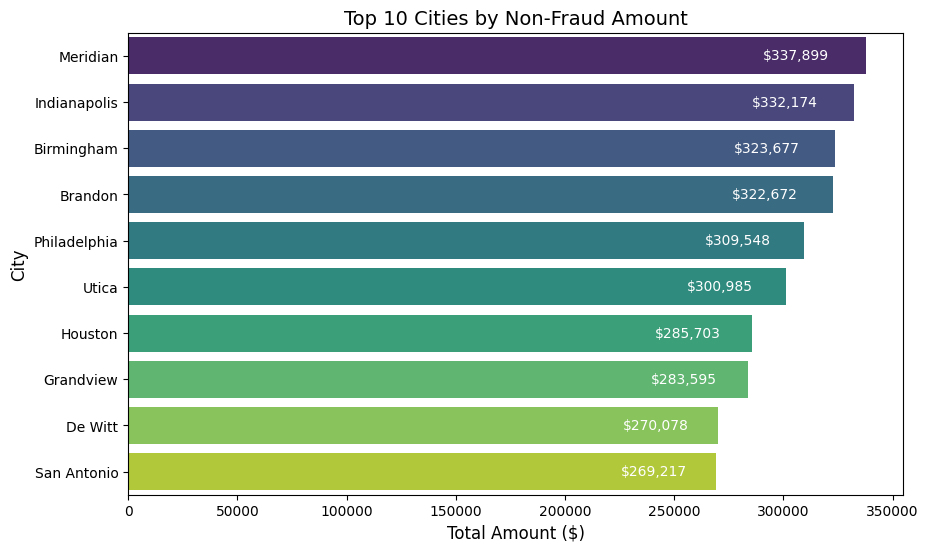

In [38]:
# Filter only fraud transactions
fraud_transactions = eda_df[eda_df['is_fraud'] == 0].copy()

# Top 10 cities by total fraud amount
fraud_by_city = (fraud_transactions
                 .groupby('city')['amt']
                 .sum()
                 .sort_values(ascending=False)
                 .head(10)
                 .reset_index())

fraud_by_city.columns = ['city', 'total_amt']

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x='total_amt',
    y='city',
    data=fraud_by_city,
    hue='city',
    palette='viridis'
)
plt.title("Top 10 Cities by Non-Fraud Amount", fontsize=14)
plt.xlabel("Total Amount ($)", fontsize=12)
plt.ylabel("City", fontsize=12)

# Annotate amounts inside bars
for i, row in fraud_by_city.iterrows():
    plt.text(row['total_amt'] - row['total_amt']*0.05, i, f"${row['total_amt']:,.0f}",
             va='center', ha='right', color='white', fontsize=10)

plt.show()

## Total Fraud Transaction Amount by State

In [39]:
# Filter fraud transactions
fraud_transactions = eda_df[eda_df['is_fraud'] == 1].copy()

# Aggregate total fraud amount by state
fraud_by_state = fraud_transactions.groupby("state")["amt"].sum().reset_index()

# Create choropleth map
fig = px.choropleth(
    fraud_by_state,
    locations='state',
    locationmode='USA-states',
    color='amt',
    title='Total Fraud Amount by State',
    color_continuous_scale='Viridis',
    labels={'amt': 'Total Fraud Amount ($)'}
)

# Limit scope to USA
fig.update_geos(scope="usa")

# Display directly in notebook
fig.show()

## Total Non-Fraud Transaction Amount by State

In [40]:
# Filter fraud transactions
fraud_transactions = eda_df[eda_df['is_fraud'] == 0].copy()

# Aggregate total fraud amount by state
fraud_by_state = fraud_transactions.groupby("state")["amt"].sum().reset_index()

# Create choropleth map
fig = px.choropleth(
    fraud_by_state,
    locations='state',
    locationmode='USA-states',
    color='amt',
    title='Total Non-Fraud Amount by State',
    color_continuous_scale='Viridis',
    labels={'amt': 'Total Non-Fraud Amount ($)'}
)

# Limit scope to USA
fig.update_geos(scope="usa")

# Display directly in notebook
fig.show()

# Model Buidling

## Dropping Unnecessary Columns

In [41]:
# Drop unwanted columns
drop_cols = ["Unnamed: 0", "amt", "cc_num", "first", "last", "street", "dob", "city", "state", "zip",
             "trans_num", "unix_time", "merch_zipcode", "trans_date_trans_time", "merchant", "category",
             "gender", "job", "trans_year", "trans_month", "trans_day", "trans_weekday", "trans_hour",
             "trans_minute", "trans_second", "trans_season"]

df = df.drop(*drop_cols)

print("Remaining columns:")
print(df.columns)

Remaining columns:
['lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud', 'log_amt', 'cardholder_age', 'merchant_index', 'category_index', 'gender_index', 'job_index']


## Defining Features and Target

In [42]:
# Target
target_col = "is_fraud"

# Features = all columns except target
feature_cols = [c for c in df.columns if c != target_col]

print("Target:", target_col)
print("Number of features:", len(feature_cols))
print("Features:", feature_cols)

Target: is_fraud
Number of features: 11
Features: ['lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'log_amt', 'cardholder_age', 'merchant_index', 'category_index', 'gender_index', 'job_index']


## Train-Test Split

In [43]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

print("Train rows:", train_df.count(), " | Test rows:", test_df.count())

Train rows: 880557  | Test rows: 220145


## Assembling Features and Scaling

In [44]:
# Assemble numeric features into one vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Apply assembler + scaler
assembled_df = assembler.transform(df)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

# Train-test split again on scaled data
train_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=42)

## Logistic Regression

In [45]:
# Model
lr = LogisticRegression(featuresCol="scaled_features", labelCol=target_col, maxIter=50)

# Train
lr_model = lr.fit(train_df)

# Predict
preds = lr_model.transform(test_df)

# Evaluate
binary_eval = BinaryClassificationEvaluator(labelCol=target_col, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")
precision_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedPrecision")
recall_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedRecall")
f1_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="f1")

print("=== Logistic Regression ===")
print(f"AUC: {binary_eval.evaluate(preds):.4f}")
print(f"Accuracy: {accuracy_eval.evaluate(preds):.4f}")
print(f"Precision: {precision_eval.evaluate(preds):.4f}")
print(f"Recall: {recall_eval.evaluate(preds):.4f}")
print(f"F1-score: {f1_eval.evaluate(preds):.4f}")

=== Logistic Regression ===
AUC: 0.8308
Accuracy: 0.9940
Precision: 0.9887
Recall: 0.9940
F1-score: 0.9913


## Decision Tree Classifier

In [46]:
# Model
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol=target_col, maxDepth=5)

# Train
dt_model = dt.fit(train_df)

# Predict
dt_preds = dt_model.transform(test_df)

# Evaluate
binary_eval = BinaryClassificationEvaluator(labelCol=target_col, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")
precision_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedPrecision")
recall_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedRecall")
f1_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="f1")

print("=== Decision Tree Classifier ===")
print(f"AUC: {binary_eval.evaluate(dt_preds):.4f}")
print(f"Accuracy: {accuracy_eval.evaluate(dt_preds):.4f}")
print(f"Precision: {precision_eval.evaluate(dt_preds):.4f}")
print(f"Recall: {recall_eval.evaluate(dt_preds):.4f}")
print(f"F1-score: {f1_eval.evaluate(dt_preds):.4f}")

=== Decision Tree Classifier ===
AUC: 0.8375
Accuracy: 0.9959
Precision: 0.9958
Recall: 0.9959
F1-score: 0.9947


## Random Forest Classifier

In [47]:
# Model
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol=target_col, numTrees=100, maxDepth=5)

# Train
rf_model = rf.fit(train_df)

# Predict
rf_preds = rf_model.transform(test_df)

# Evaluate
binary_eval = BinaryClassificationEvaluator(labelCol=target_col, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")
precision_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedPrecision")
recall_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedRecall")
f1_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="f1")

print("=== Random Forest Classifier ===")
print(f"AUC: {binary_eval.evaluate(rf_preds):.4f}")
print(f"Accuracy: {accuracy_eval.evaluate(rf_preds):.4f}")
print(f"Precision: {precision_eval.evaluate(rf_preds):.4f}")
print(f"Recall: {recall_eval.evaluate(rf_preds):.4f}")
print(f"F1-score: {f1_eval.evaluate(rf_preds):.4f}")

=== Random Forest Classifier ===
AUC: 0.8871
Accuracy: 0.9945
Precision: 0.9933
Recall: 0.9945
F1-score: 0.9919


## Gradient-Boosted Trees (GBT)

In [52]:
# Model
gbt = GBTClassifier(featuresCol="scaled_features", labelCol=target_col, maxIter=50, maxDepth=5)

# Train
gbt_model = gbt.fit(train_df)

# Predict
gbt_preds = gbt_model.transform(test_df)

# Evaluate
binary_eval = BinaryClassificationEvaluator(labelCol=target_col, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")
precision_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedPrecision")
recall_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedRecall")
f1_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="f1")

print("=== Gradient-Boosted Trees ===")
print(f"AUC: {binary_eval.evaluate(gbt_preds):.4f}")
print(f"Accuracy: {accuracy_eval.evaluate(gbt_preds):.4f}")
print(f"Precision: {precision_eval.evaluate(gbt_preds):.4f}")
print(f"Recall: {recall_eval.evaluate(gbt_preds):.4f}")
print(f"F1-score: {f1_eval.evaluate(gbt_preds):.4f}")

=== Gradient-Boosted Trees ===
AUC: 0.9796
Accuracy: 0.9961
Precision: 0.9957
Recall: 0.9961
F1-score: 0.9953


## Linear Support Vector Classifier (LinearSVC)

In [49]:
# Model
svc = LinearSVC(featuresCol="scaled_features", labelCol=target_col, maxIter=50)

# Train
svc_model = svc.fit(train_df)

# Predict
svc_preds = svc_model.transform(test_df)

# Evaluate
accuracy_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")
precision_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedPrecision")
recall_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedRecall")
f1_eval = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="f1")

print("=== LinearSVC ===")
print(f"Accuracy: {accuracy_eval.evaluate(svc_preds):.4f}")
print(f"Precision: {precision_eval.evaluate(svc_preds):.4f}")
print(f"Recall: {recall_eval.evaluate(svc_preds):.4f}")
print(f"F1-score: {f1_eval.evaluate(svc_preds):.4f}")

=== LinearSVC ===
Accuracy: 0.9943
Precision: 0.9887
Recall: 0.9943
F1-score: 0.9915


# Feature Importance for Gradient-Boosted Trees (GBT)

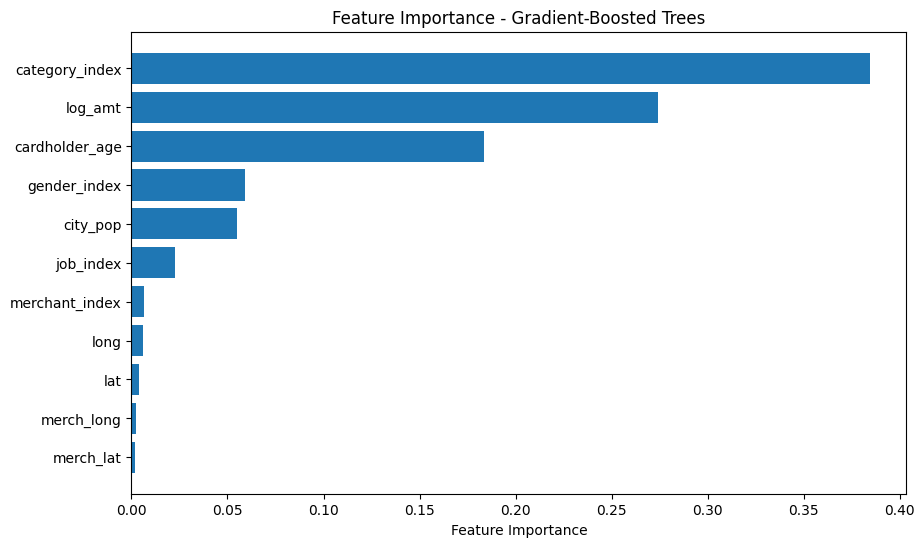

In [53]:
# Extract feature importances
importances = gbt_model.featureImportances.toArray()  # gbt_model = trained GBTClassifier
features = feature_cols  # your list of feature names

# Create DataFrame for plotting
feat_imp = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel("Feature Importance")
plt.title("Feature Importance - Gradient-Boosted Trees")
plt.gca().invert_yaxis()  # highest importance on top
plt.show()

# ROC Curve for Gradient-Boosted Trees (GBT)

ROC AUC: 0.9796


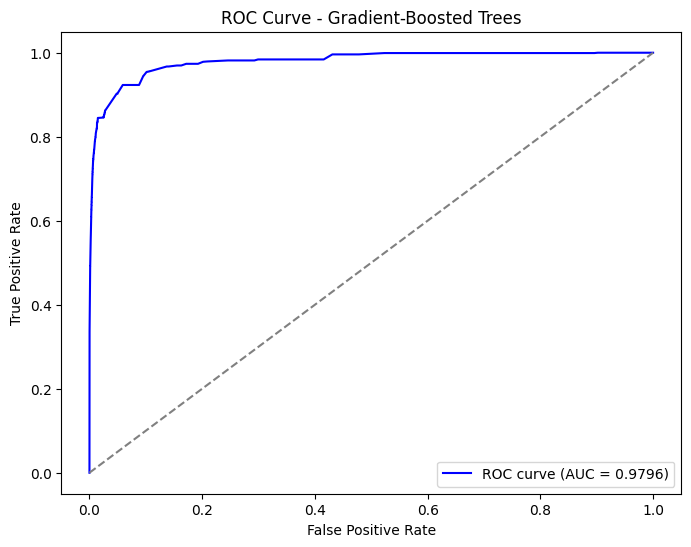

In [54]:
# Convert rawPrediction vector to array
preds_array = gbt_preds.withColumn("raw_array", vector_to_array("rawPrediction"))

# Extract positive-class score (fraud)
preds_prob = preds_array.withColumn("prob", col("raw_array")[1])

# Convert to Pandas
roc_df = preds_prob.select("prob", target_col).toPandas()

# Ensure target column is 0/1 integer
roc_df[target_col] = roc_df[target_col].astype(int)

y_true = roc_df[target_col].values
y_score = roc_df['prob'].values

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient-Boosted Trees")
plt.legend()
plt.show()